In [1]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from spikelib.utils import check_directory, datasets_to_array

# %matplotlib notebook 

In [2]:
def get_char_array(ffile):
    fields = [('latency_on', 'f8'), ('latency_off', 'f8'), ('bias_idx', 'f8'),
              ('decay_on', 'f8'), ('decay_off', 'f8'), ('resp_idx_on', 'f8'),
              ('resp_idx_off', 'f8'), ('sust_index_on', 'f8'), ('sust_index_off', 'f8'),
              ('frmax_on', 'f8'), ('frmax_off', 'f8'),
              ]
    char_dtype = np.dtype(fields)
    arr, key = datasets_to_array(ffile)
    char_array = np.zeros(arr.shape[0], dtype=char_dtype)
    for kidx, (field, dtype) in enumerate(fields):
        char_array[field] = arr[:,kidx]
    return char_array, key

In [3]:
# source_file = '../data/processed_protocols/MR-0092t2_analysis_of_protocols.hdf5'
source_file = '../data/processed_protocols/MR-0092t2_modified_analysis_of_protocols_150um_merge.hdf5'
exp_name = 'MR-0092t2'
prefix = 'nd5'
suffix= '_modified'
output_folder = '../fig/flash/'
check_directory(output_folder)



# Plot Flash characteristics from different intensities

* Columns = intensities
* Rows = latency, peak_response, sustained index, bias_idx

/flash/nd5_050/char/


/home/cesar/Software/anaconda3/envs/piptest/lib/python2.7/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/cesar/Software/anaconda3/envs/piptest/lib/python2.7/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


/flash/nd5_100/char/
/flash/nd5_150/char/
/flash/nd5_200/char/
/flash/nd5_255/char/


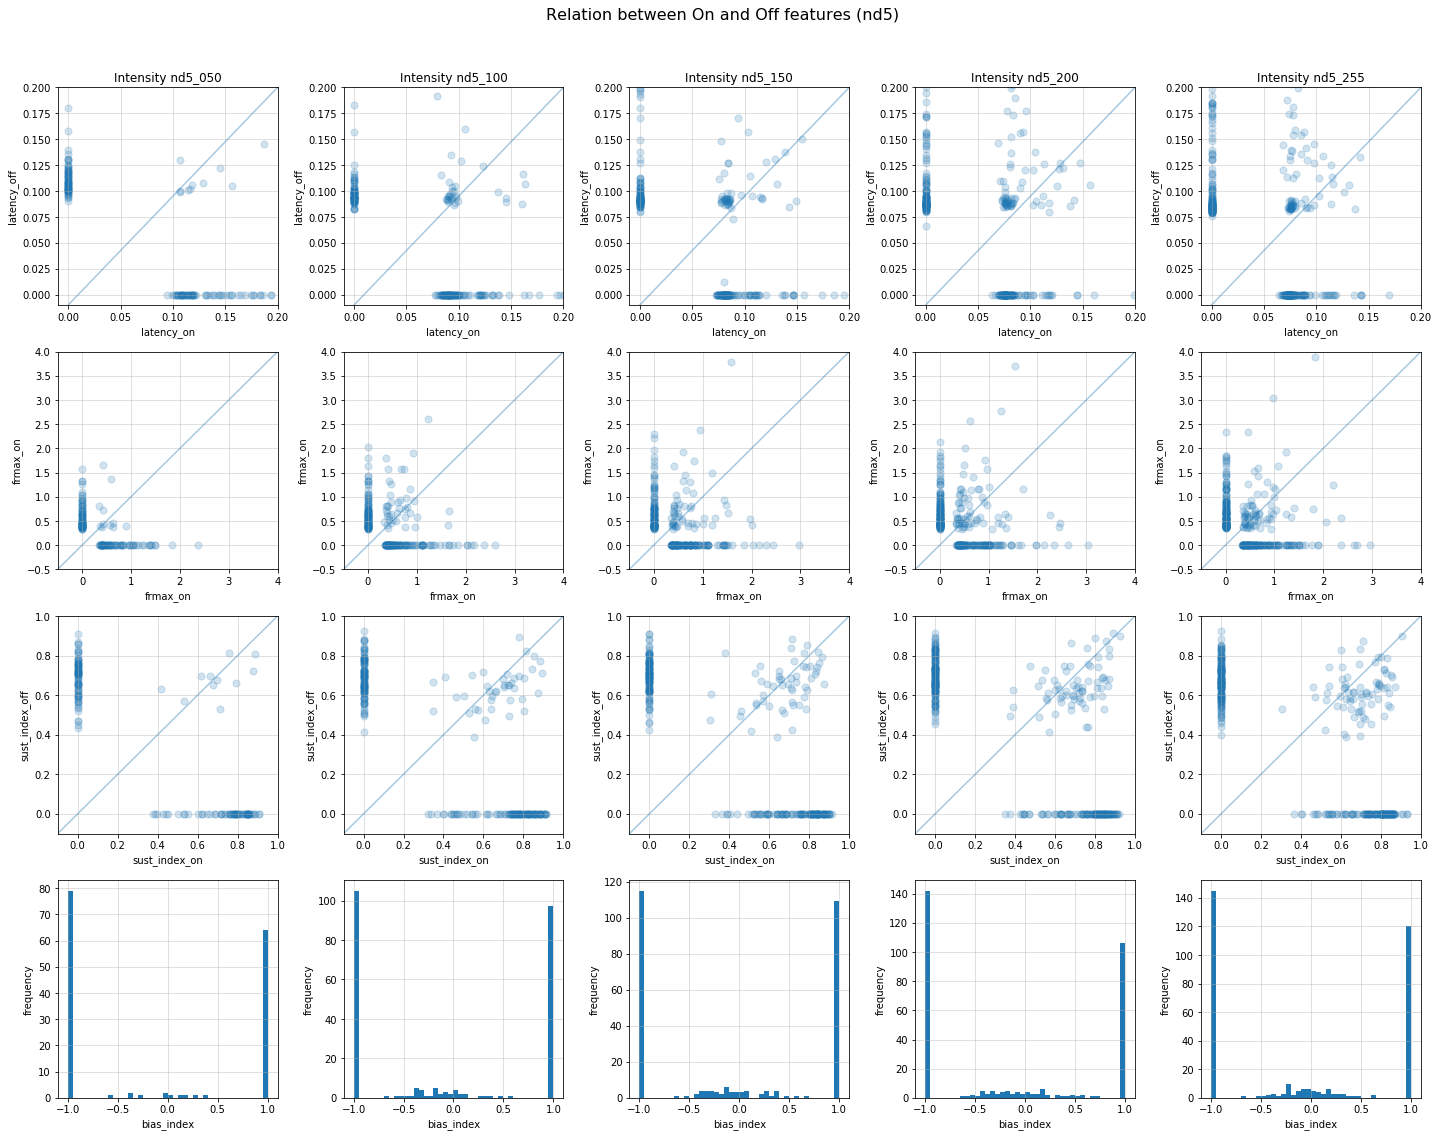

In [4]:
output_file = '{path}{exp}_{prefix}_relation_On-Off_features{suffix}'.format(
    path=output_folder, exp=exp_name, prefix=prefix, suffix=suffix)

intensities = [prefix+'_'+kint for kint in ['050', '100', '150', '200', '255']]

fig, ax = plt.subplots(4,5,figsize=(20,15), sharex=False, sharey=False)
for kidx, kintensity in enumerate(intensities):
    flash_charg = '/flash/{}/char/'.format(kintensity)
    with h5py.File(source_file)  as panalysis:
        print(flash_charg)
        intensity, key = get_char_array(panalysis[flash_charg])
    
    ax[0,kidx].scatter(intensity['latency_on'],intensity['latency_off'], alpha=0.2, s=50);
    ax[1,kidx].scatter(intensity['frmax_on'],intensity['frmax_off'], alpha=0.2, s=50);
    ax[2,kidx].scatter(intensity['sust_index_on'],intensity['sust_index_off'], alpha=0.2, s=50);
    ax[3,kidx].hist(intensity['bias_idx'], bins=40, range=(-1,1));
    ax[0,kidx].set_xlim([-0.01,0.2])
    ax[0,kidx].set_ylim([-0.01,0.2])
    ax[0,kidx].plot([-0.0,0.2], [-0.01,0.2], alpha = 0.4)
    ax[1,kidx].set_xlim([-0.5,4])
    ax[1,kidx].set_ylim([-0.5,4])
    ax[1,kidx].plot([-0.5,4], [-0.5,4], alpha = 0.4)
    ax[2,kidx].set_xlim([-0.1,1])
    ax[2,kidx].set_ylim([-0.1,1])
    ax[2,kidx].plot([-0.1,1], [-0.1,1], alpha = 0.4)
#     ax[3,kidx].set_ylim([0,70])
    
    ax[0,kidx].set_xlabel('latency_on')
    ax[0,kidx].set_ylabel('latency_off')
    ax[1,kidx].set_xlabel('frmax_on')
    ax[1,kidx].set_ylabel('frmax_on')
    ax[2,kidx].set_xlabel('sust_index_on')
    ax[2,kidx].set_ylabel('sust_index_off')
    ax[3,kidx].set_xlabel('bias_index')
    ax[3,kidx].set_ylabel('frequency')
    ax[0,kidx].set_title('Intensity '+kintensity)
for kax in ax.flatten():
    kax.grid(alpha=0.5)

fig.suptitle('Relation between On and Off features ({})'.format(prefix), y=1.05, fontsize=16)
plt.tight_layout()
plt.savefig(output_file+'.png', bbox_inches='tight')
# plt.savefig(output_file, format='pdf',  bbox_inches='tight')

# Plot Flash response for different classification
* Columns = intensities
* Rows = Null, On, Off, On-Off

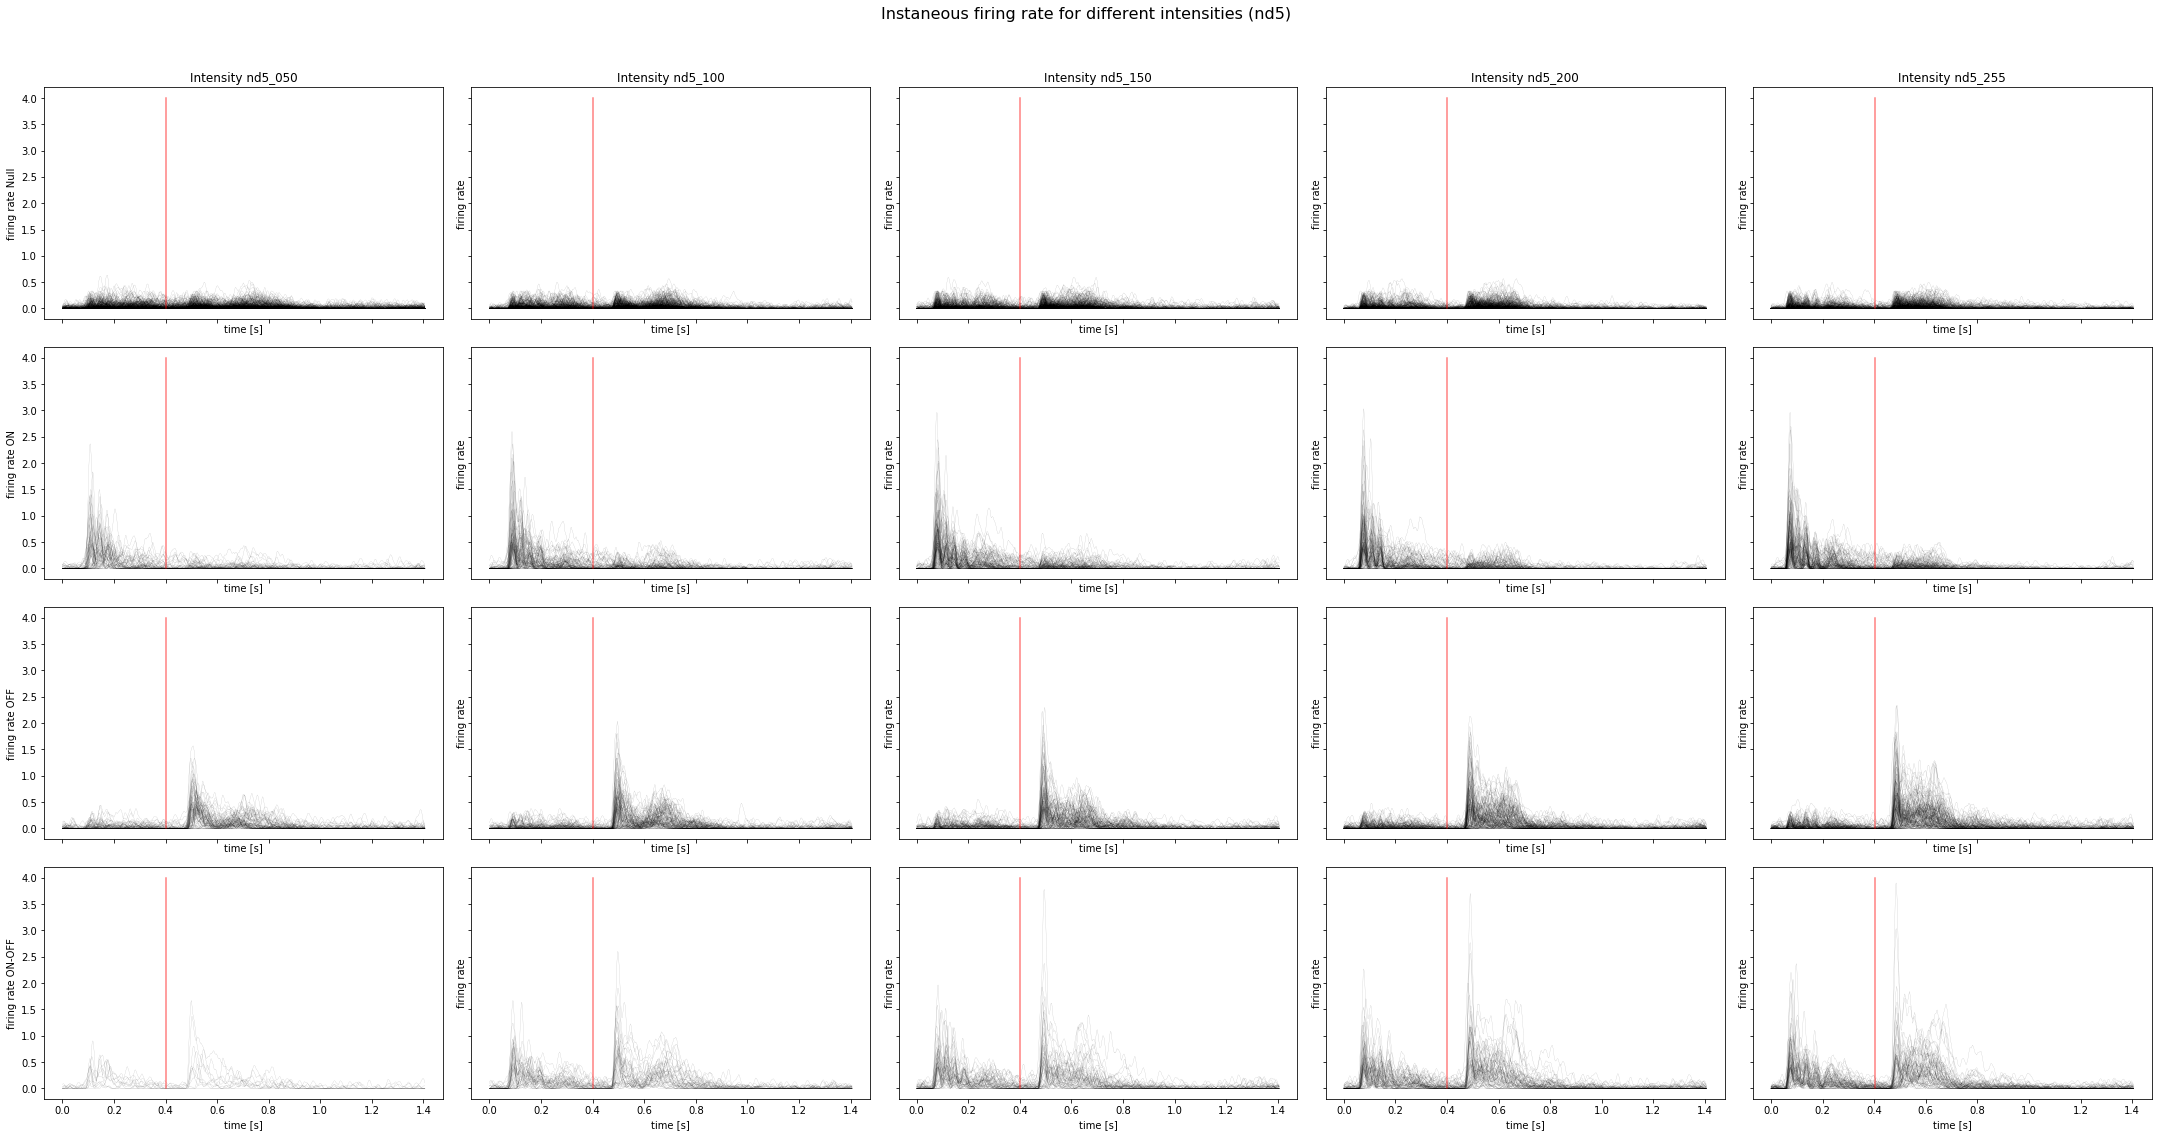

In [5]:
output_file = '{path}{exp}_{prefix}_response_{suffix}'.format(
    path=output_folder, exp=exp_name, prefix=prefix, suffix=suffix)

intensities = [prefix+'_'+kint for kint in ['050', '100', '150', '200', '255']]


fig, ax = plt.subplots(4,5,figsize=(30,15), sharex=True, sharey=True)
for kint_idx, kintensity in enumerate(intensities):
    flash_estfrg = '/flash/{}/est_psth/'.format(kintensity)
    flash_typeg = '/flash/{}/type/'.format(kintensity)
    with h5py.File(source_file)  as panalysis:
        flash_type, key_type = datasets_to_array(panalysis[flash_typeg])
        estfr, key_estfr = datasets_to_array(panalysis[flash_estfrg])
        start_on, end_on, start_off, end_off = panalysis[flash_estfrg].attrs['bounds']
        time_response = panalysis[flash_estfrg].attrs['time']
    
    for (resp, ftype) in zip(estfr, flash_type.flatten().astype('int')):
        ax[ftype][kint_idx].plot(time_response, resp, alpha=0.3, color='k', lw=0.2)
        
for kax in ax.flatten():
    kax.set(xlabel='time [s]', ylabel='firing rate')
    ymin, ymax = (0,4)
    kax.plot([start_off, start_off], [ymin, ymax], c='r', alpha=0.5)
for kax, kname in zip(ax[0], intensities):
    kax.set(title='Intensity '+kname)
for kax, kname in zip(ax[:,0], ['Null', 'ON', 'OFF', 'ON-OFF']):
    label = kax.get_ylabel()
    kax.set(ylabel='{} {}'.format(label, kname))

fig.suptitle('Instaneous firing rate for different intensities ({})'.format(prefix), y=1.05, fontsize=16)

plt.tight_layout()
plt.savefig(output_file+'.png', bbox_inches='tight')
# plt.savefig(output_file+'.pdf', bbox_inches='tight')

# Temporal relation between intensities 255 vs 100-50 

In [6]:
output_file = '{path}{exp}_{prefix}_relation_255_vs_200-150-100-50{suffix}'.format(
    path=output_folder, exp=exp_name, prefix=prefix, suffix=suffix)

intensities = ['{}_{}'.format(prefix, kint) for kint in [50, 100, 150, 200, 255]]

In [7]:
keys = {}
chars = {}
with h5py.File(source_file)  as panalysis:
    flash_group = panalysis['/flash/']
    for intensity in flash_group:
        char, key = get_char_array(flash_group[intensity]['char'])
        chars[intensity] = char
        keys[intensity] = key

#  Relationtion between 255 and 200-150-100-50

In [8]:
def plot_flash(ax, x, y , limits, **kwds):
    ax.scatter(x, y, alpha=0.3, s=10, **kwds)
    ax.plot(limits, limits, alpha=0.2, color='r')
    ax.grid(alpha=0.4, ls=':')
    return ax

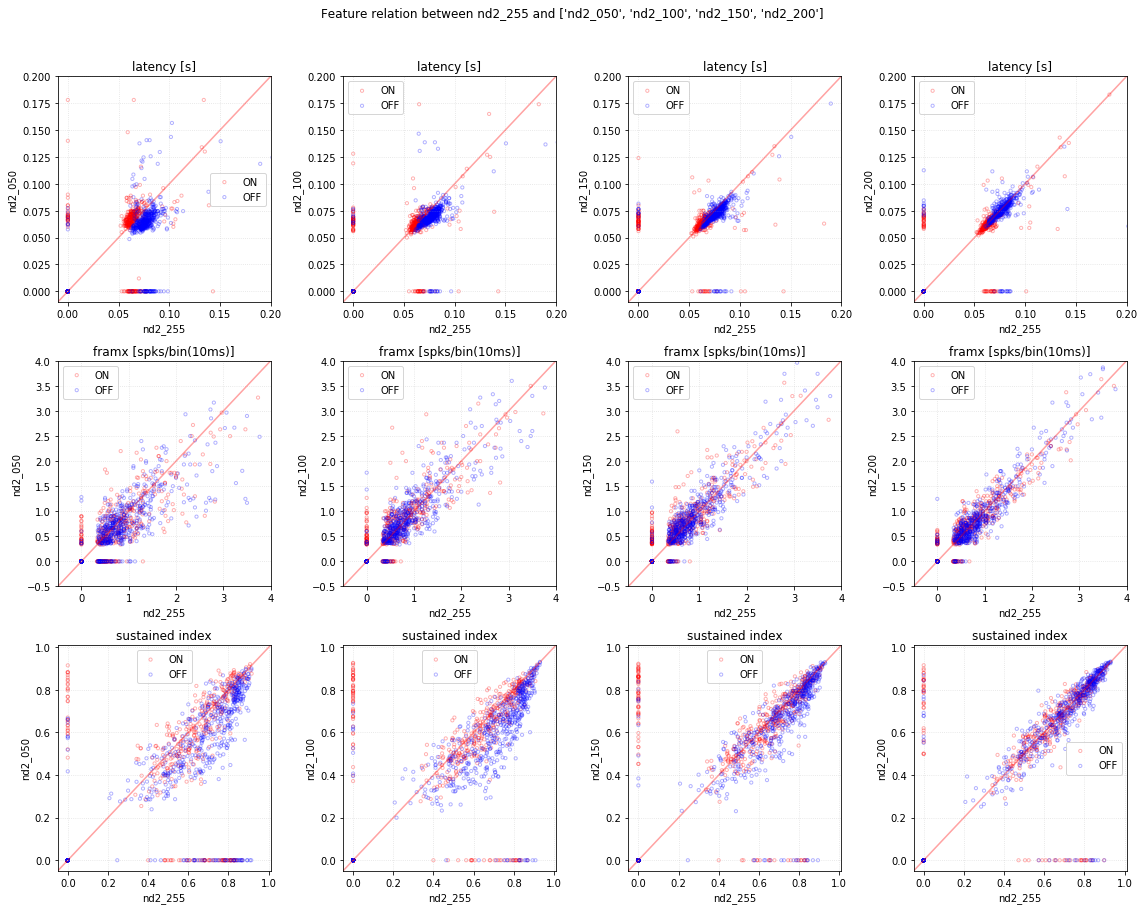

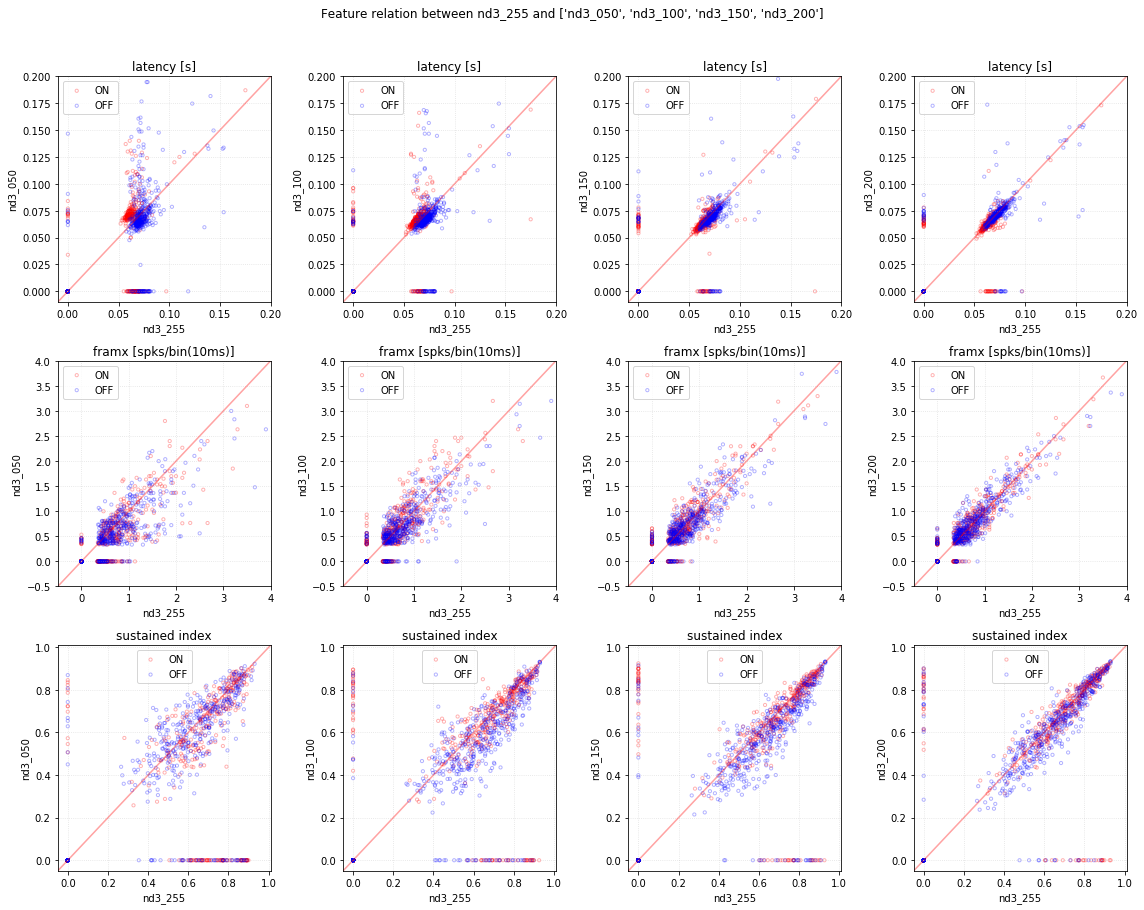

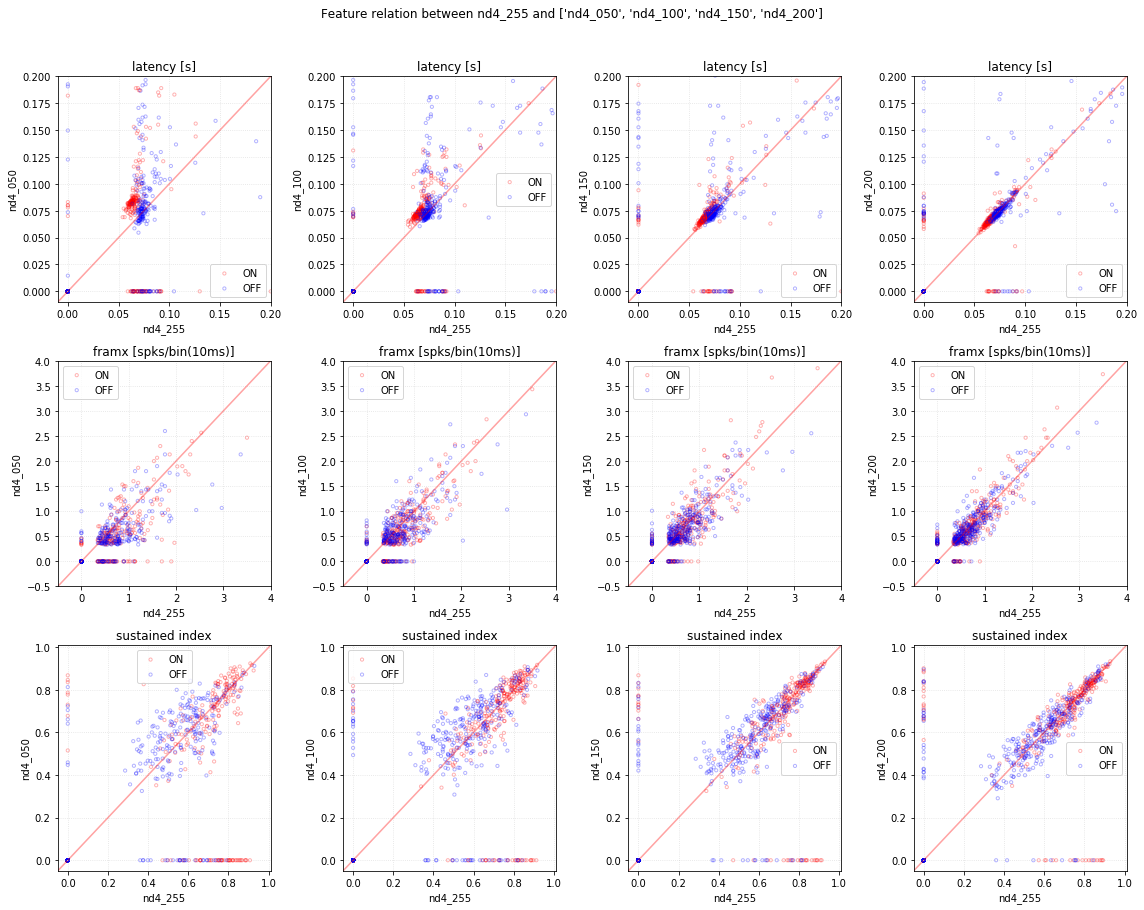

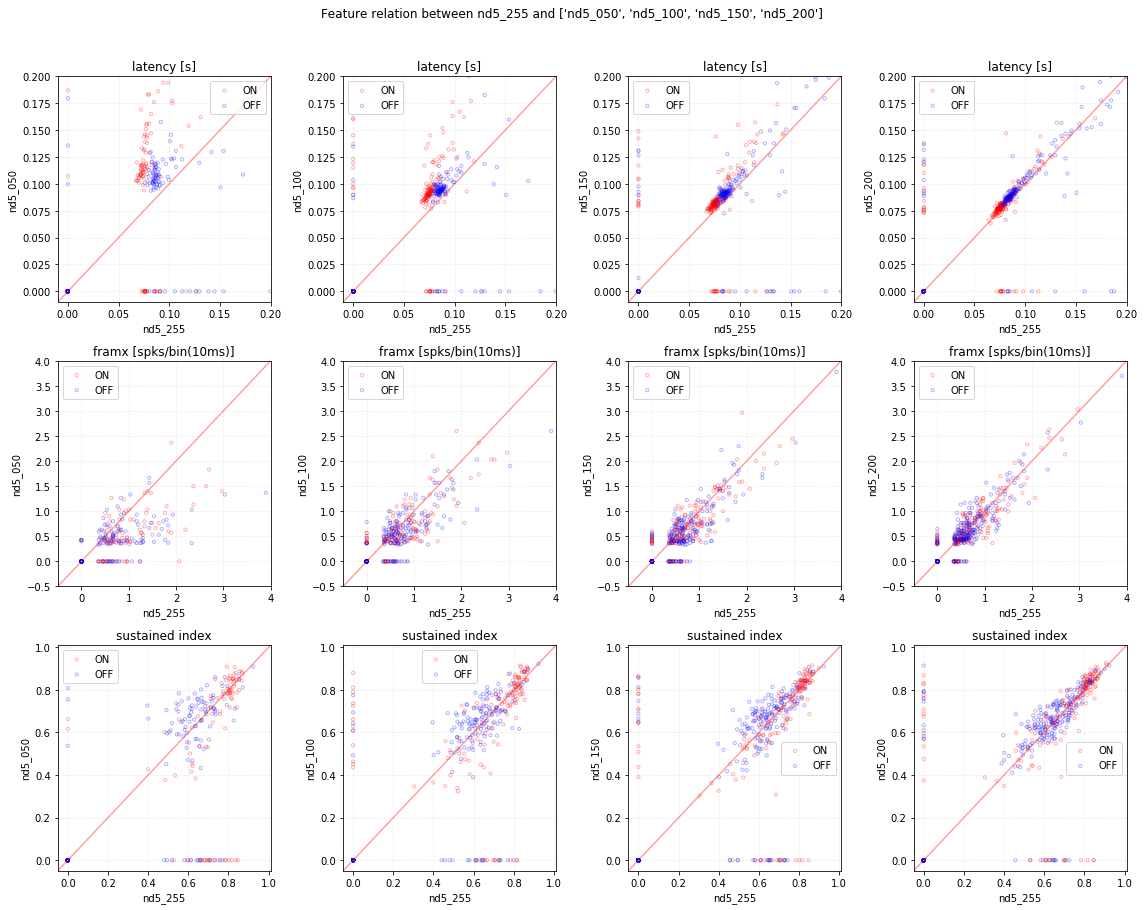

In [9]:
output_file = '{path}{exp}_{prefix}_relation_255_vs_200-150-100-50{suffix}'.format(
    path=output_folder, exp=exp_name, prefix=prefix, suffix=suffix)

prefixs = ['nd2', 'nd3', 'nd4', 'nd5']
vs_intensity = 255
flash_intensities = [50, 100, 150, 200]

for prefix in prefixs:
    intensities = ['{}_{:03d}'.format(prefix, kint) for kint in flash_intensities]
    contrast = '{}_{:03d}'.format(prefix, vs_intensity)

    
    fig, ax = plt.subplots(3,4,figsize=(16,12))
    kwds_on = {'facecolors': 'None', 'edgecolors': 'r', 'label': 'ON'}
    kwds_off = {'facecolors': 'None', 'edgecolors': 'b', 'label': 'OFF'}

    for kidx, kintensity in enumerate(intensities):
        field = 'latency_on'
        limits = [-0.01, 0.2]
        kax = plot_flash(ax[0][kidx], chars[contrast][field], chars[kintensity][field] , limits, **kwds_on)
        field = 'latency_off'
        kax = plot_flash(ax[0][kidx], chars[contrast][field], chars[kintensity][field] , limits, **kwds_off)
        kax.set(xlim=limits, ylim=limits, xlabel=contrast, ylabel=kintensity, title='latency [s]')


        field = 'frmax_on'
        limits = [-0.5, 4]
        kax = plot_flash(ax[1][kidx], chars[contrast][field], chars[kintensity][field] , limits, **kwds_on)
        field = 'frmax_off'
        kax = plot_flash(ax[1][kidx], chars[contrast][field], chars[kintensity][field] , limits, **kwds_off)
        kax.set(xlim=limits, ylim=limits, xlabel=contrast, ylabel=kintensity, title='framx [spks/bin(10ms)]')

        field = 'sust_index_on'
        limits = [-0.05, 1.01]
        kax = plot_flash(ax[2][kidx], chars[contrast][field], chars[kintensity][field] , limits, **kwds_on)
        field = 'sust_index_off'
        kax = plot_flash(ax[2][kidx], chars[contrast][field], chars[kintensity][field] , limits, **kwds_off)
        kax.set(xlim=limits, ylim=limits, xlabel=contrast, ylabel=kintensity, title='sustained index')
        
    for kax in ax.flatten():
        kax.legend()
    fig.suptitle('Feature relation between {} and {}'.format(contrast, intensities), y=1.05)
    plt.tight_layout()
    # fig.savefig(output_file+'_on-off.pdf', bbox_inches='tight')
    fig.savefig(output_file+'_{}.png'.format(prefix), bbox_inches='tight')
plt.show()

## Histograms

In [10]:
output_file = '{path}{exp}_{prefix}_histograms_255_vs_200-150-100-50{suffix}'.format(
    path=output_folder, exp=exp_name, prefix=prefix, suffix=suffix)

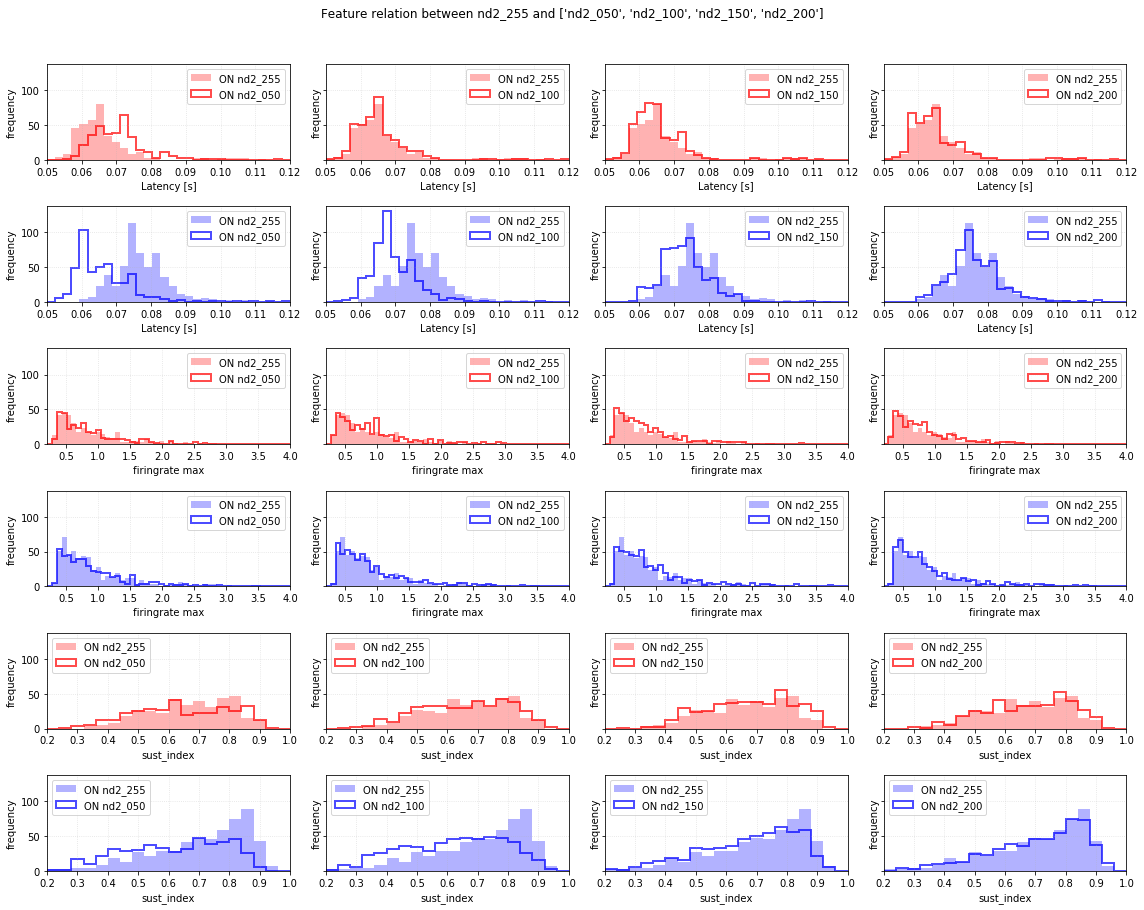

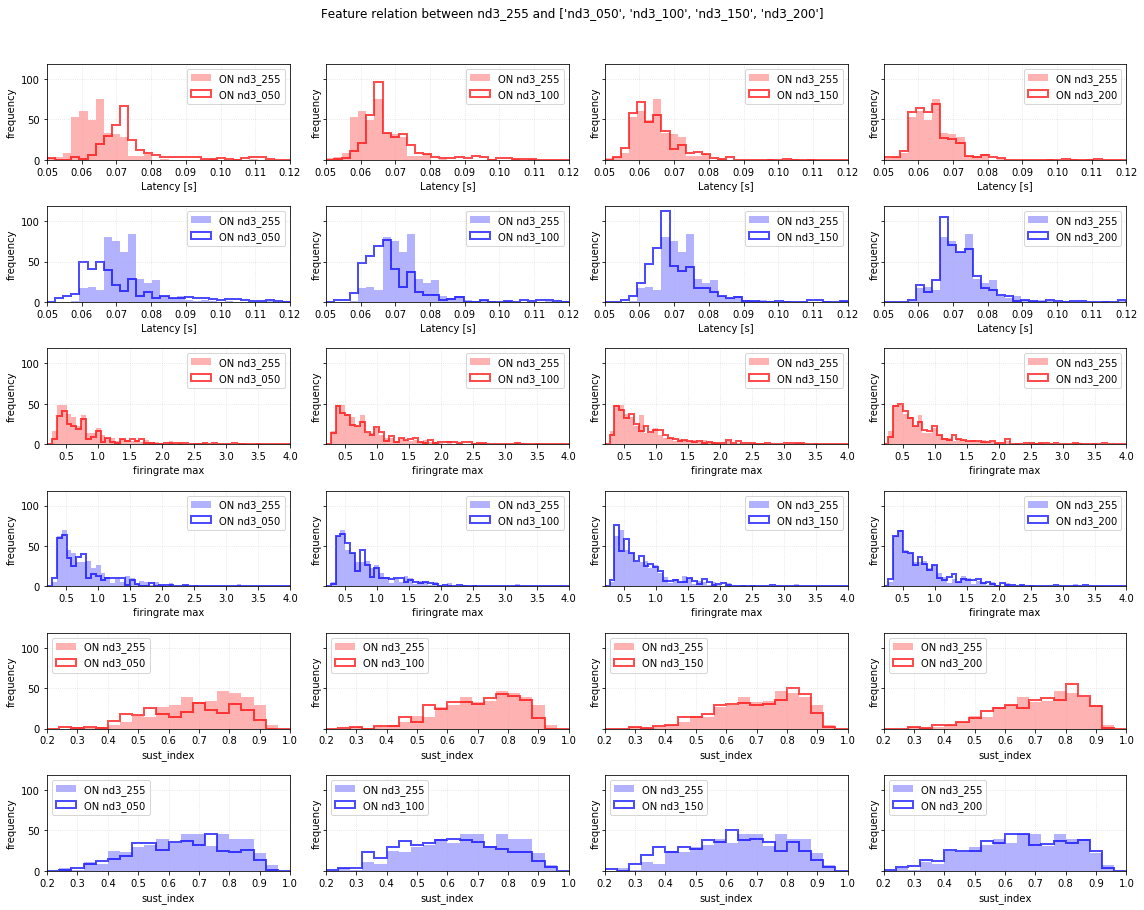

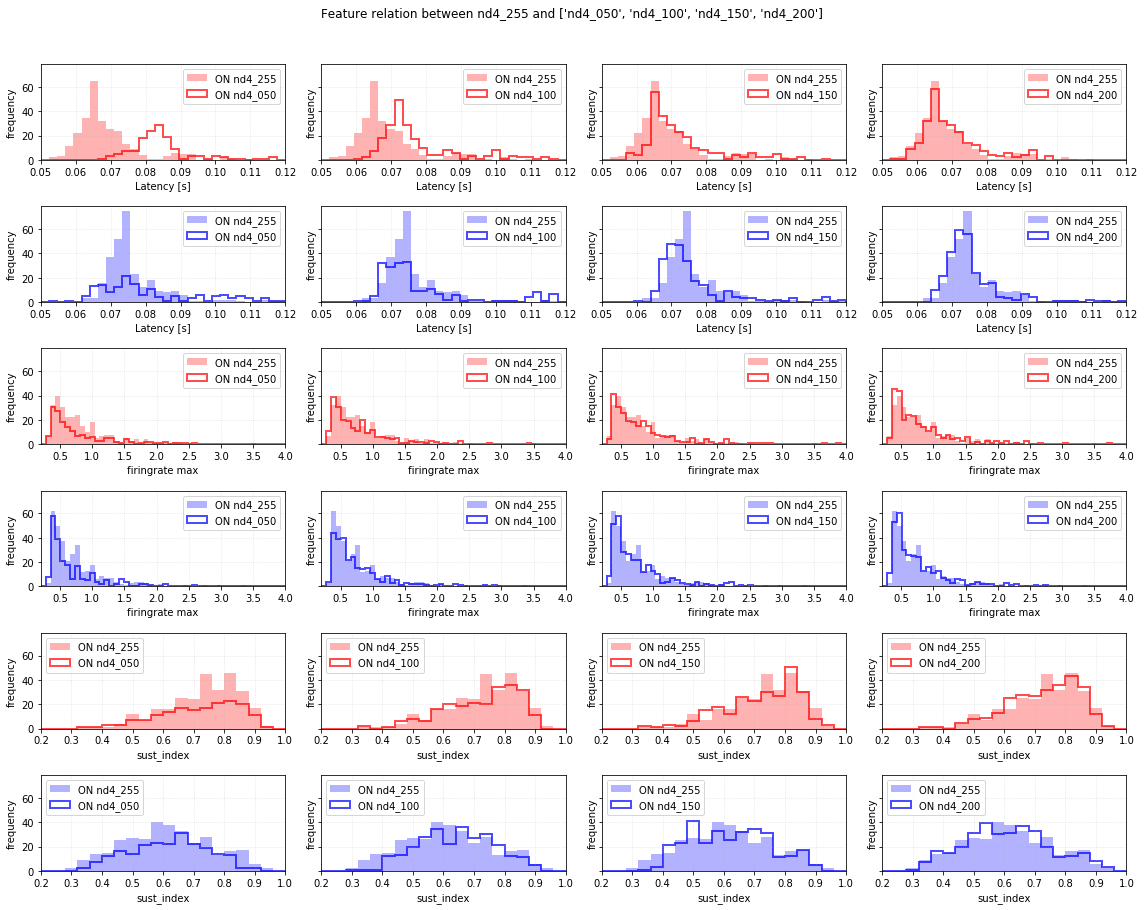

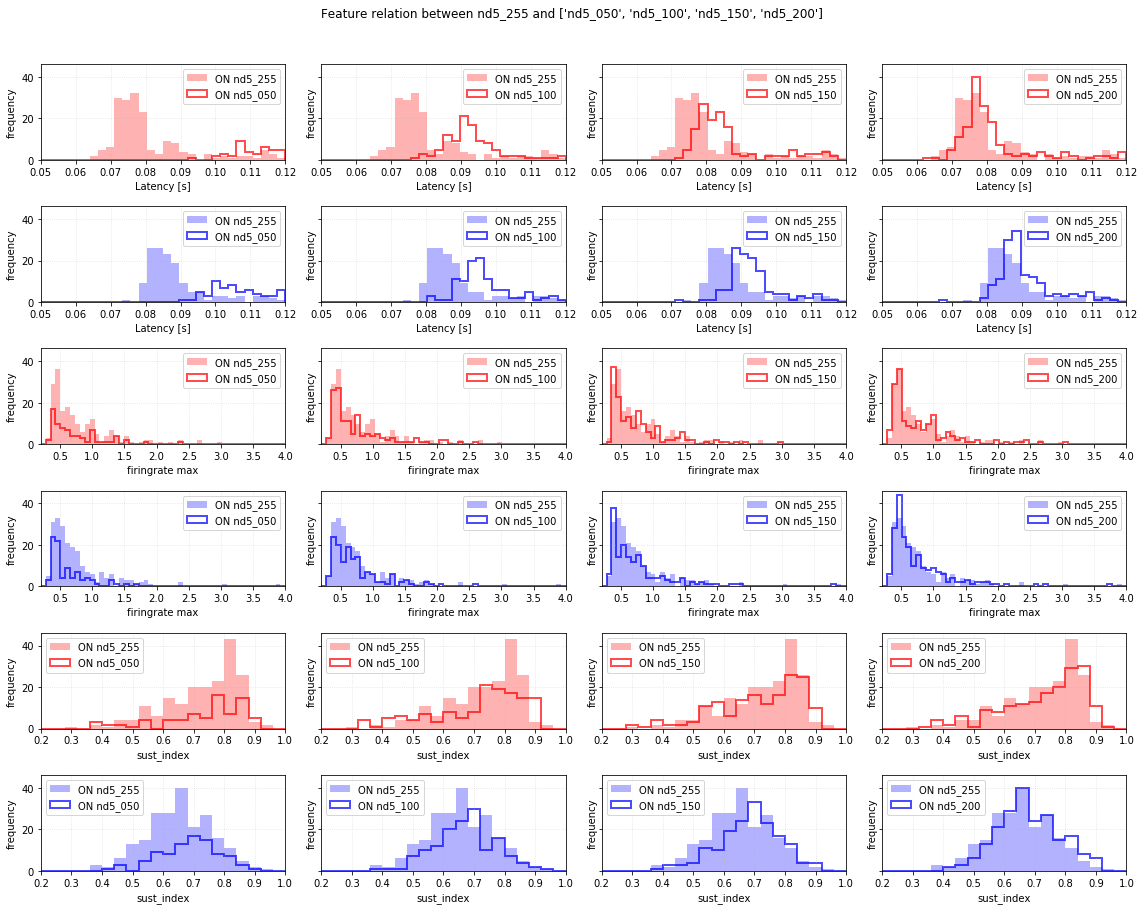

In [11]:
prefixs = ['nd2', 'nd3', 'nd4', 'nd5', ]
vs_intensity = 255
flash_intensities = [50, 100, 150, 200]

for prefix in prefixs:
    intensities = ['{}_{:03d}'.format(prefix, kint) for kint in flash_intensities]
    contrast = '{}_{:03d}'.format(prefix, vs_intensity)
    
    fig, ax = plt.subplots(6,4,figsize=(16,12), sharey=True)
    for kidx, kintensity in enumerate(intensities):
        field = 'latency_on'
        limits = [0.05, 0.12]
        kwargs1 = {'bins':30, 'range':tuple(limits), 'alpha':0.3, 'color':'red', 'lw':2, 'ls':'-','label':'ON '+contrast, 'histtype': 'bar', }
        kwargs2 = {'bins':30, 'range':tuple(limits), 'alpha':0.7, 'color':'red', 'lw':2, 'ls':'-','label':'ON '+kintensity, 'histtype': 'step', }
        kwargs3 = {'bins':30, 'range':tuple(limits), 'alpha':0.3, 'color':'blue', 'lw':2, 'ls':'-','label':'ON '+contrast, 'histtype': 'bar', }
        kwargs4 = {'bins':30, 'range':tuple(limits), 'alpha':0.7, 'color':'blue', 'lw':2, 'ls':'-','label':'ON '+kintensity, 'histtype': 'step',}
        ax[0][kidx].hist(chars[contrast][field], **kwargs1)
        ax[0][kidx].hist(chars[kintensity][field], **kwargs2)
        ax[0][kidx].set(xlim=limits, xlabel='Latency [s]', ylabel='frequency', )
        ax[0][kidx].legend()
        field = 'latency_off'
        ax[1][kidx].hist(chars[contrast][field], **kwargs3)
        ax[1][kidx].hist(chars[kintensity][field], **kwargs4)
        ax[1][kidx].set(xlim=limits, xlabel='Latency [s]', ylabel='frequency', )
        ax[1][kidx].legend()


        field = 'frmax_on'
        limits = [0.2, 4]
        kwargs1 = {'bins':50, 'range':tuple(limits), 'alpha':0.3, 'color':'red', 'lw':2, 'ls':'-','label':'ON '+contrast, 'histtype': 'bar', }
        kwargs2 = {'bins':50, 'range':tuple(limits), 'alpha':0.7, 'color':'red', 'lw':2, 'ls':'-','label':'ON '+kintensity, 'histtype': 'step', }
        kwargs3 = {'bins':50, 'range':tuple(limits), 'alpha':0.3, 'color':'blue', 'lw':2, 'ls':'-','label':'ON '+contrast, 'histtype': 'bar', }
        kwargs4 = {'bins':50, 'range':tuple(limits), 'alpha':0.7, 'color':'blue', 'lw':2, 'ls':'-','label':'ON '+kintensity, 'histtype': 'step',}
        ax[2][kidx].hist(chars[contrast][field], **kwargs1)
        ax[2][kidx].hist(chars[kintensity][field], **kwargs2)
        ax[2][kidx].set(xlim=limits, xlabel='firingrate max', ylabel='frequency')
        ax[2][kidx].legend()
        field = 'frmax_off'
        ax[3][kidx].hist(chars[contrast][field], **kwargs3)
        ax[3][kidx].hist(chars[kintensity][field], **kwargs4)
        ax[3][kidx].set(xlim=limits, xlabel='firingrate max', ylabel='frequency')
        ax[3][kidx].legend()

        field = 'sust_index_on'
        limits = [0.2, 1.0]
        kwargs1 = {'bins':20, 'range':tuple(limits), 'alpha':0.3, 'color':'red', 'lw':2, 'ls':'-','label':'ON '+contrast, 'histtype': 'bar', }
        kwargs2 = {'bins':20, 'range':tuple(limits), 'alpha':0.7, 'color':'red', 'lw':2, 'ls':'-','label':'ON '+kintensity, 'histtype': 'step', }
        kwargs3 = {'bins':20, 'range':tuple(limits), 'alpha':0.3, 'color':'blue', 'lw':2, 'ls':'-','label':'ON '+contrast, 'histtype': 'bar', }
        kwargs4 = {'bins':20, 'range':tuple(limits), 'alpha':0.7, 'color':'blue', 'lw':2, 'ls':'-','label':'ON '+kintensity, 'histtype': 'step',}
        ax[4][kidx].hist(chars[contrast][field], **kwargs1)
        ax[4][kidx].hist(chars[kintensity][field], **kwargs2)
        ax[4][kidx].legend(loc=2)
        ax[4][kidx].set(xlim=limits, xlabel='sust_index', ylabel='frequency')
        field = 'sust_index_off'
        ax[5][kidx].hist(chars[contrast][field], **kwargs3)
        ax[5][kidx].hist(chars[kintensity][field], **kwargs4)
        ax[5][kidx].legend(loc=2)
        ax[5][kidx].set(xlim=limits, xlabel='sust_index', ylabel='frequency')
        
    for kax in ax.flatten():
        kax.grid(alpha=0.4, ls=':')
    fig.suptitle('Feature relation between {} and {}'.format(contrast, intensities), y=1.05)
    plt.tight_layout()
    fig.savefig(output_file+'_{}.png'.format(prefix), bbox_inches='tight')
plt.show()

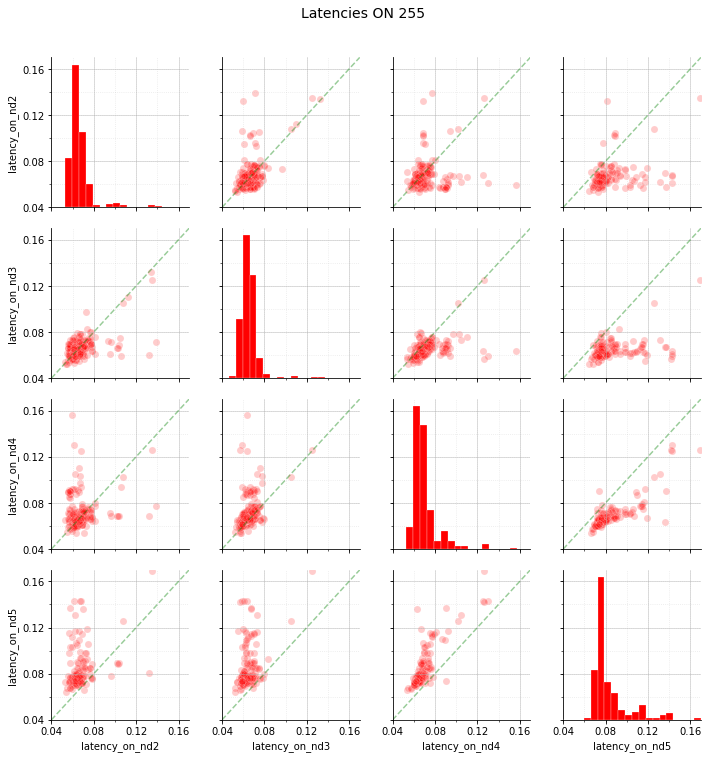

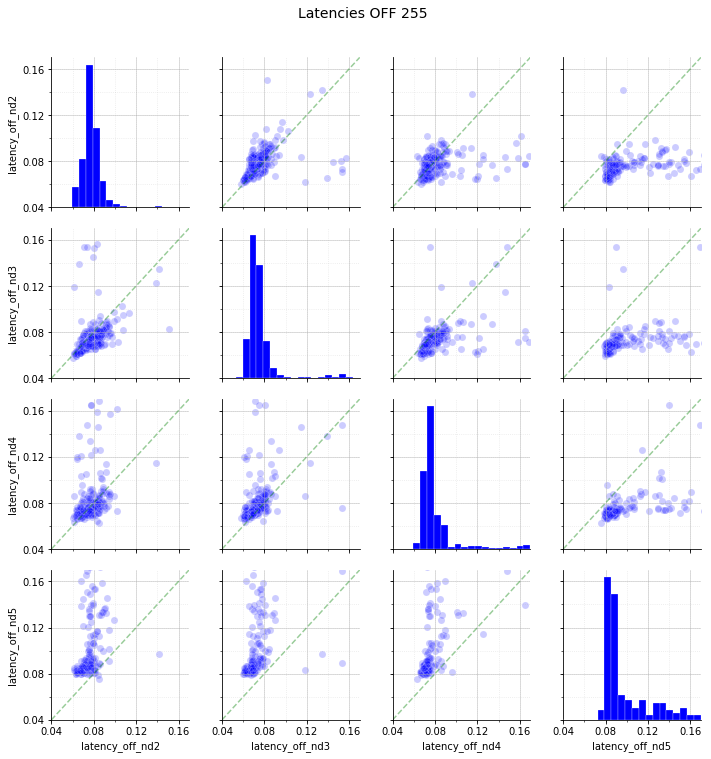

In [12]:
sta_intensity = 255
output_file = '{path}{exp}_{prefix}_pairplot-{intensity:03d}_latency{suffix}'.format(
    path=output_folder, exp=exp_name, prefix=prefix, suffix=suffix, intensity=sta_intensity)

prefixs = ['nd2', 'nd3', 'nd4', 'nd5', ]


df = pd.DataFrame({})
for prefix in prefixs:
    intensity = '{}_{:03d}'.format(prefix, sta_intensity) 
    df['latency_on_'+prefix] = chars[intensity]['latency_on']
    df['latency_off_'+prefix] = chars[intensity]['latency_off']


on_cols = ['latency_on_nd2', 'latency_on_nd3',  'latency_on_nd4',  'latency_on_nd5']
off_cols = ['latency_off_nd2','latency_off_nd3','latency_off_nd4', 'latency_off_nd5']



ranges = (0.04, 0.17)
df_plot = df.fillna(0)
pair_on = sns.pairplot(df_plot[on_cols],  plot_kws=dict(s=50, edgecolors='None', facecolors='r', alpha=0.2, marker='o'),
                 diag_kws={'edgecolor':'white', 'facecolor': 'r', 'lw':0.25, 'bins':20, 'range':ranges})
for kidx, ax in enumerate(pair_on.axes.flat):
    if kidx not in [0,5,10,15]:
        ax.plot(ranges, ranges, c='g', ls='--', alpha=0.4)
    ax.grid(alpha=0.5, which='major', ls='-')
    ax.grid(alpha=0.3, which='minor', ls=':')
    ax.xaxis.set_ticks(np.arange(0.04, 0.17, 0.04))
    ax.xaxis.set_ticks(np.arange(0.04, 0.17, 0.02), minor=True)
    ax.yaxis.set_ticks(np.arange(0.04, 0.17, 0.04))
    ax.yaxis.set_ticks(np.arange(0.04, 0.17, 0.02), minor=True)
    ax.set(xlim=ranges, ylim=ranges)
plt.suptitle('Latencies ON {}'.format(sta_intensity), size = 14, y=1.05);
plt.savefig(output_file+'_ON.png', bbox_inches='tight')


pair_off = sns.pairplot(df_plot[off_cols],  plot_kws=dict(s=50, edgecolors='None', facecolors='b', alpha=0.2, marker='o'),
                 diag_kws={'edgecolor':'white', 'facecolor': 'b', 'lw':0.25, 'bins':20, 'range':ranges})
for kidx, ax in enumerate(pair_off.axes.flat):
    if kidx not in [0,5,10,15]:
        ax.plot(ranges, ranges, c='g', ls='--', alpha=0.4)
    ax.grid(alpha=0.5, which='major', ls='-')
    ax.grid(alpha=0.3, which='minor', ls=':')
    ax.xaxis.set_ticks(np.arange(0.04, 0.17, 0.04))
    ax.xaxis.set_ticks(np.arange(0.04, 0.17, 0.02), minor=True)
    ax.yaxis.set_ticks(np.arange(0.04, 0.17, 0.04))
    ax.yaxis.set_ticks(np.arange(0.04, 0.17, 0.02), minor=True)
    ax.set(xlim=ranges, ylim=ranges)
plt.suptitle('Latencies OFF {}'.format(sta_intensity), size = 14, y=1.05);
plt.savefig(output_file+'_OFF.png', bbox_inches='tight')
        
plt.show()

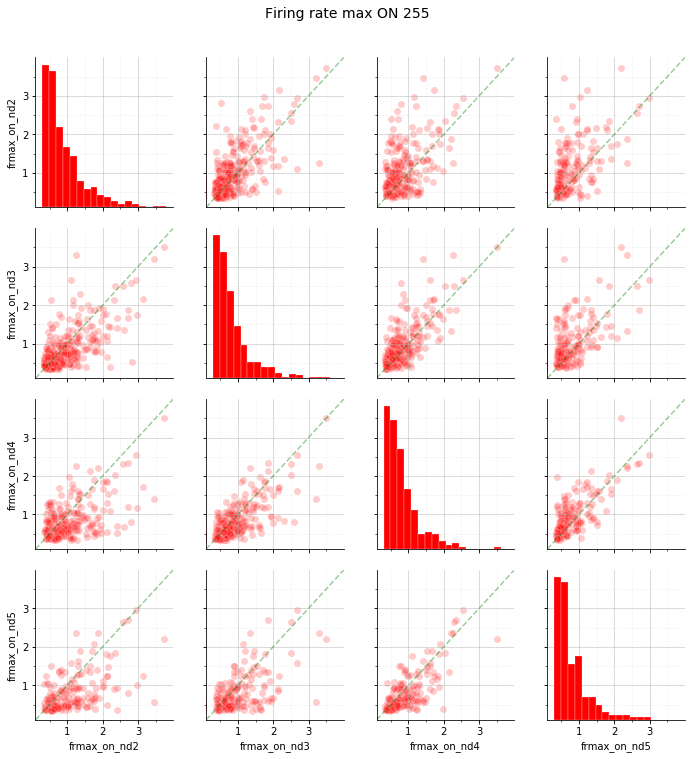

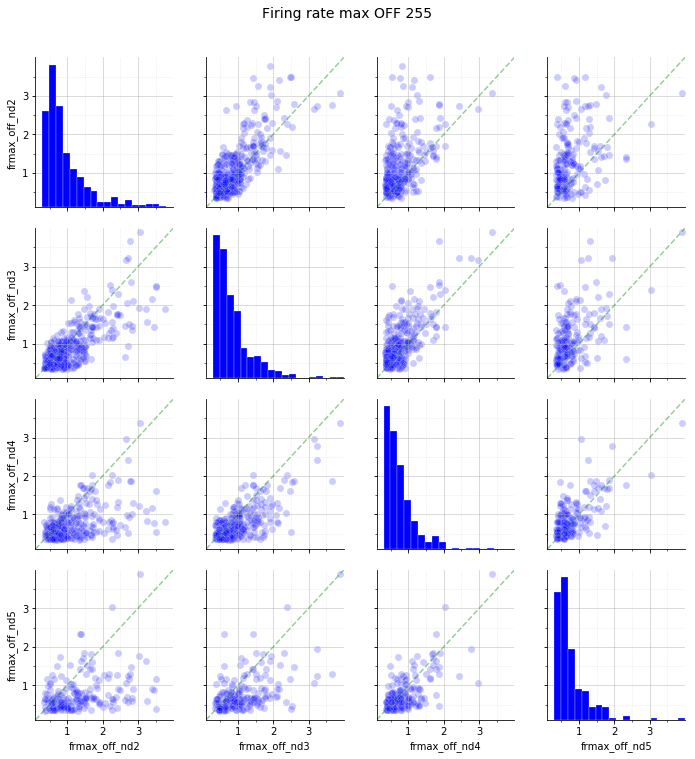

In [13]:
prefixs = ['nd2', 'nd3', 'nd4', 'nd5', ]
sta_intensity = 255
output_file = '{path}{exp}_{prefix}_pairplot-{intensity:03d}_frmax{suffix}'.format(
    path=output_folder, exp=exp_name, prefix=prefix, suffix=suffix, intensity=sta_intensity)

df = pd.DataFrame({})
for prefix in prefixs:
    intensity = '{}_{:03d}'.format(prefix, sta_intensity) 
    df['frmax_on_'+prefix] = chars[intensity]['frmax_on']
    df['frmax_off_'+prefix] = chars[intensity]['frmax_off']


on_cols = ['frmax_on_'+prefix for prefix in prefixs ]
off_cols = ['frmax_off_'+prefix for prefix in prefixs ]



ranges = (0.1, 4)
df_plot = df.fillna(0)
pair_on = sns.pairplot(df_plot[on_cols],  plot_kws=dict(s=50, edgecolors='None', facecolors='r', alpha=0.2, marker='o'),
                 diag_kws={'edgecolor':'white',  'facecolor':'r', 'lw':0.25, 'bins':20, 'range':ranges})
for kidx, ax in enumerate(pair_on.axes.flat):
    if kidx not in [0,5,10,15]:
        ax.plot(ranges, ranges, c='g', ls='--', alpha=0.4)
    ax.grid(alpha=0.5, which='major', ls='-')
    ax.grid(alpha=0.3, which='minor', ls=':')
    ax.xaxis.set_ticks(np.arange(0.0, 4, 1))
    ax.xaxis.set_ticks(np.arange(0.0, 4, 0.5), minor=True)
    ax.yaxis.set_ticks(np.arange(0.0, 4, 1))
    ax.yaxis.set_ticks(np.arange(0.0, 4, 0.5), minor=True)
    ax.set(xlim=ranges, ylim=ranges)
    
plt.suptitle('Firing rate max ON {}'.format(sta_intensity), size = 14, y=1.05);
plt.savefig(output_file+'_ON.png', bbox_inches='tight')


pair_off = sns.pairplot(df_plot[off_cols],  plot_kws=dict(s=50, edgecolors='None', facecolors='b', alpha=0.2, marker='o'),
                 diag_kws={'edgecolor':'white', 'facecolor':'b', 'lw':0.25, 'bins':20, 'range':ranges})
for kidx, ax in enumerate(pair_off.axes.flat):
    if kidx not in [0,5,10,15]:
        ax.plot(ranges, ranges, c='g', ls='--', alpha=0.4)
    ax.grid(alpha=0.5, which='major', ls='-')
    ax.grid(alpha=0.3, which='minor', ls=':')
    ax.xaxis.set_ticks(np.arange(0.0, 4, 1))
    ax.xaxis.set_ticks(np.arange(0.0, 4, 0.5), minor=True)
    ax.yaxis.set_ticks(np.arange(0.0, 4, 1))
    ax.yaxis.set_ticks(np.arange(0.0, 4, 0.5), minor=True)
    ax.set(xlim=ranges, ylim=ranges)
plt.suptitle('Firing rate max OFF {}'.format(sta_intensity), size = 14, y=1.05);
plt.savefig(output_file+'_OFF.png', bbox_inches='tight')
        
plt.show()

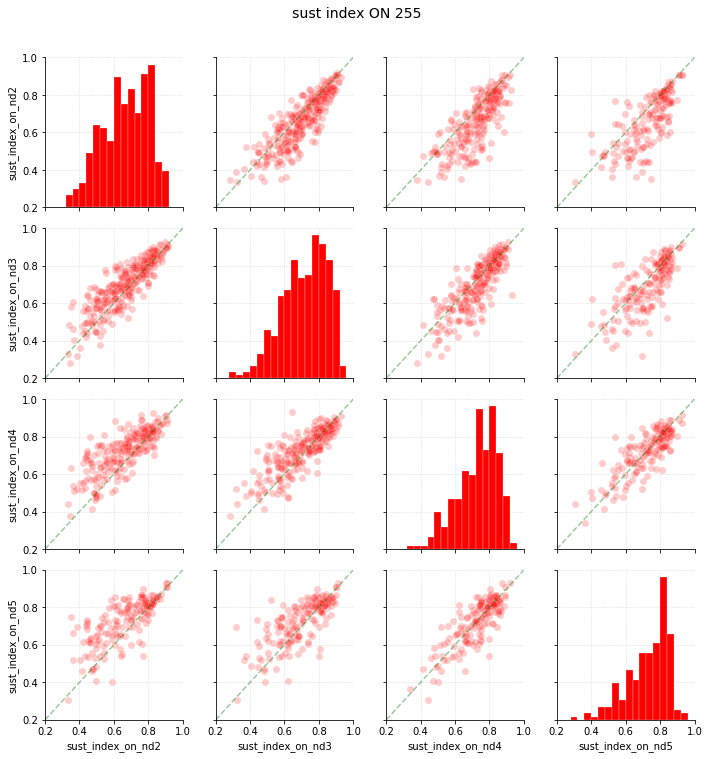

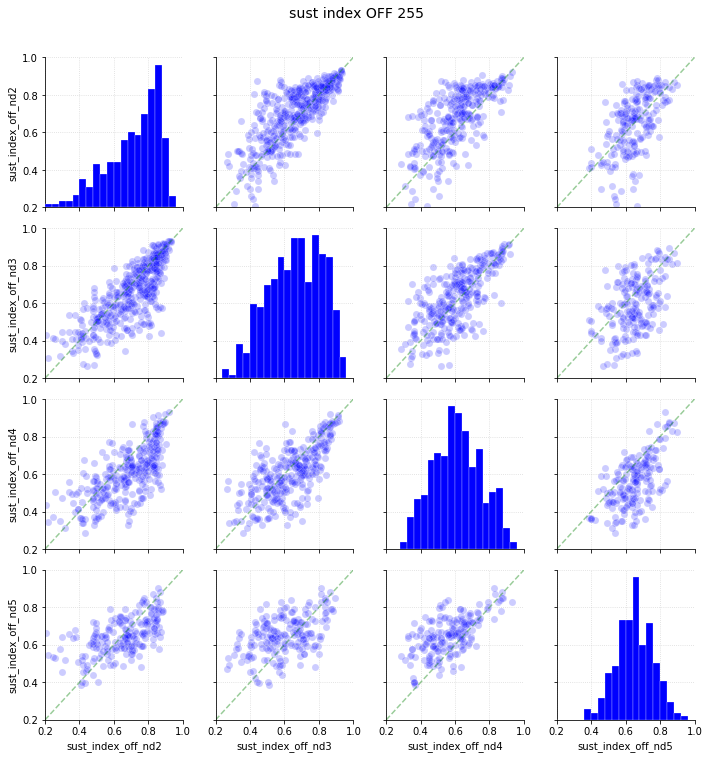

In [14]:
prefixs = ['nd2', 'nd3', 'nd4', 'nd5', ]
sta_intensity = 255
output_file = '{path}{exp}_{prefix}_pairplot-{intensity:03d}_sust_inx{suffix}'.format(
    path=output_folder, exp=exp_name, prefix=prefix, suffix=suffix, intensity=sta_intensity)

df = pd.DataFrame({})
for prefix in prefixs:
    intensity = '{}_{:03d}'.format(prefix, sta_intensity) 
    df['sust_index_on_'+prefix] = chars[intensity]['sust_index_on']
    df['sust_index_off_'+prefix] = chars[intensity]['sust_index_off']


on_cols = ['sust_index_on_'+prefix for prefix in prefixs ]
off_cols = ['sust_index_off_'+prefix for prefix in prefixs ]



ranges = (0.2, 1)
df_plot = df.fillna(0)
pair_on = sns.pairplot(df_plot[on_cols],  plot_kws=dict(s=50, edgecolors='None', facecolors='r', alpha=0.2, marker='o'),
                 diag_kws={'edgecolor':'white', 'facecolor':'r', 'lw':0.25, 'bins':20, 'range':ranges})
for kidx, ax in enumerate(pair_on.axes.flat):
    if kidx not in [0,5,10,15]:
        ax.plot(ranges, ranges, c='g', ls='--', alpha=0.4)
    ax.set(xlim=ranges, ylim=ranges)
    ax.grid(alpha=0.5, which='both', ls=':')
    ax.xaxis.set_ticks(np.arange(0.0, 1.1, 0.2))
#     ax.xaxis.set_ticks(np.arange(0.0, 1, 0.1), minor=True)
    ax.yaxis.set_ticks(np.arange(0.0, 1.1, 0.2))
#     ax.yaxis.set_ticks(np.arange(0.0, 1, 0.1), minor=True)
    ax.set(xlim=ranges, ylim=ranges)
plt.suptitle('sust index ON {}'.format(sta_intensity), size = 14, y=1.05);
plt.savefig(output_file+'_ON.png', bbox_inches='tight')


pair_off = sns.pairplot(df_plot[off_cols],  plot_kws=dict(s=50, edgecolors='None', facecolors='b', alpha=0.2, marker='o'),
                 diag_kws={'edgecolor':'white', 'facecolor':'b', 'lw':0.25, 'bins':20, 'range':ranges})
for kidx, ax in enumerate(pair_off.axes.flat):
    if kidx not in [0,5,10,15]:
        ax.plot(ranges, ranges, c='g', ls='--', alpha=0.4)
    ax.grid(alpha=0.5, which='both', ls=':')
    ax.xaxis.set_ticks(np.arange(0.0, 1.1, 0.2))
#     ax.xaxis.set_ticks(np.arange(0.0, 1, 0.1), minor=True)
    ax.yaxis.set_ticks(np.arange(0.0, 1.1, 0.2))
#     ax.yaxis.set_ticks(np.arange(0.0, 1, 0.1), minor=True)
    ax.set(xlim=ranges, ylim=ranges)

plt.suptitle('sust index OFF {}'.format(sta_intensity), size = 14, y=1.05);
plt.savefig(output_file+'_OFF.png', bbox_inches='tight')
        
plt.show()

In [15]:
plt.close('all')